# Semi-Supervised Learning example with MNIST dataset


In [1]:
# import libraries
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

# my implementations
from models.AutoEncoder_Linear import AutoEncoder_Linear
from models.AutoEncoder_Convolutional import AutoEncoder_Convolutional
from util.mnist_loader import load_mnist_semisupervised, load_mnist
from util.ModelHandler import ModelHandler

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Download Dataset

There is a simple Python script that you can download and save mnist dataset as a `pickle` file. You can uncomment next chunk and run it to download the dataset!

In [2]:
# !python util/mnist-downloader.py

## Import the data

### Meet the requirements for the Training data

* Labeled Data:  
    1 per class (total=10)

In [3]:
mnist_path = "./data/mnist.pkl"

# this function takes N samples for each labels as labeled and unlabeled
# if N_unlabeled=0, it will take all observations except sampled labeled observations
data_dict = load_mnist_semisupervised(mnist_path,
                                      N_labeled=1,
                                      N_unlabeled=0, 
                                      seed=1)

x_train_labeled = data_dict["x_train_labeled"]
x_train_unlabeled = data_dict["x_train_unlabeled"]
y_train_labeled = data_dict["y_train_labeled"]
y_train_unlabeled = data_dict["y_train_unlabeled"]

x_test = data_dict["x_test"]
y_test = data_dict["y_test"]

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Labeled Train Shape   : (10, 784)
UnLabeled Train Shape : (59998, 784)


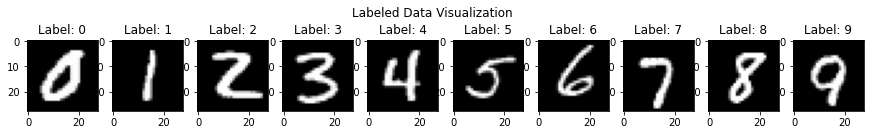

In [4]:
# Visualize Labeled Data
fig, axs = plt.subplots(1, 10, figsize=(15, 2))

for c in range(10):
    img = x_train_labeled[c].reshape(28, 28)
    axs[c].imshow(img, cmap='gray')
    axs[c].set_title(f"Label: {c}")
    
fig.suptitle("Labeled Data Visualization")

plt.show()

# AutoEncoder Training

## Linear AutoEncoder

### Pytorch Linear Datasets (, 784)

In [5]:
x_train_unlabeled.shape

(59998, 784)

In [6]:
dataset_train = TensorDataset(torch.Tensor(x_train_unlabeled), 
                              torch.zeros(x_train_unlabeled.shape[0]))

train_dataloader_linear = DataLoader(dataset_train,
                                     batch_size=64,
                                     shuffle=True,
                                     num_workers=8,
                                     pin_memory=False)


dataset_test = TensorDataset(torch.Tensor(x_test), 
                             torch.Tensor(y_test))

test_dataloader_linear = DataLoader(dataset_test,
                                    batch_size=64,
                                    shuffle=False,
                                    num_workers=8,
                                    pin_memory=True)

### Training


In [7]:
model_args = {
    "input_shape": 784,
    "symetric_dimensions": (128, 128),
    "activation_function": torch.relu
}

optimizer_args = {
    "lr": 1e-3
}

model_handler_linear = ModelHandler(ModelClass=AutoEncoder_Linear, 
                             model_args_dict=model_args,
                             optimizer=optim.Adam,
                             optimizer_args_dict=optimizer_args,
                             criterion=nn.MSELoss)

In [8]:
%%time
model_handler_linear.train(train_dataloader_linear, epochs=20)

epoch: 1/20, loss=0.03494544271757004, 3.31s
epoch: 2/20, loss=0.013576970506173524, 3.13s
epoch: 3/20, loss=0.009981188484763445, 3.21s
epoch: 4/20, loss=0.008149393020507528, 3.18s
epoch: 5/20, loss=0.0070333159215915115, 3.06s
epoch: 6/20, loss=0.0062181358806479145, 3.28s
epoch: 7/20, loss=0.0056030655931085666, 3.26s
epoch: 8/20, loss=0.00514680228785856, 2.84s
epoch: 9/20, loss=0.00478734121372951, 3.71s
epoch: 10/20, loss=0.004491867377672956, 3.00s
epoch: 11/20, loss=0.004261107399448085, 3.18s
epoch: 12/20, loss=0.004049626085956865, 3.13s
epoch: 13/20, loss=0.00387139214517505, 3.13s
epoch: 14/20, loss=0.0037069469943507584, 2.84s
epoch: 15/20, loss=0.003553219635271902, 3.05s
epoch: 16/20, loss=0.0034244695250421507, 3.07s
epoch: 17/20, loss=0.0033019926306654588, 3.12s
epoch: 18/20, loss=0.003200120825036518, 3.10s
epoch: 19/20, loss=0.0030966803807812903, 2.96s
epoch: 20/20, loss=0.002998448964178578, 2.85s
CPU times: user 1min 32s, sys: 8.61 s, total: 1min 40s
Wall time: 

### Plot Labeled Data Reconstruction

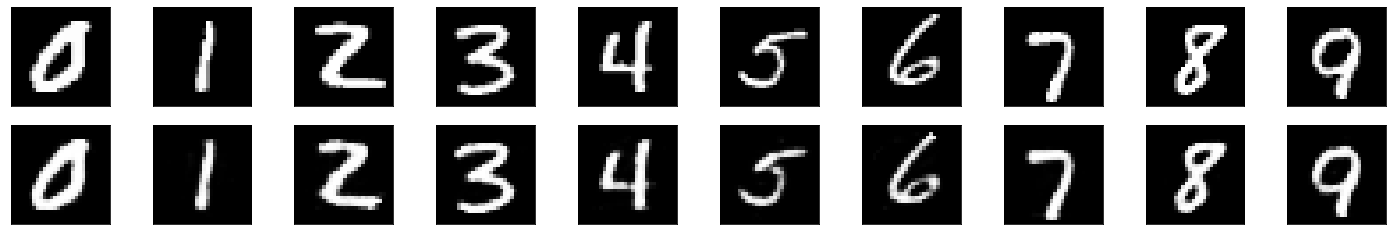

In [9]:
X = torch.Tensor(x_train_labeled)

X_reconst = model_handler_linear.predict(X)

N_row = 2
N_col = 10
fig, axes = plt.subplots(nrows=N_row, ncols=N_col, 
                         sharex=True, sharey=True, 
                         figsize=(25,4))

for imgs, row in zip([X.reshape(-1,28,28), 
                      X_reconst.reshape(-1,28,28)], 
                     axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [10]:
preds = []
for batch, _ in test_dataloader_linear:
    batch = batch.to(model_handler_linear.device)
    out = \
        model_handler_linear.model.extract_representation(batch).cpu().detach().numpy()
    preds.append(out)

## Convolutional AutoEncoder

### Pytorch Matrix Datasets (, 1, 28, 28)

In [11]:
dataset_train = \
    TensorDataset(torch.Tensor(x_train_unlabeled.reshape(-1, 1, 28, 28)), 
                  torch.zeros(x_train_unlabeled.shape[0]))

train_dataloader_matrix = DataLoader(dataset_train,
                                     batch_size=64,
                                     shuffle=True,
                                     num_workers=8,
                                     pin_memory=False)


dataset_test = \
    TensorDataset(torch.Tensor(x_test.reshape(-1, 1, 28, 28)), 
                  torch.Tensor(y_test))

test_dataloader_matrix = DataLoader(dataset_test,
                                    batch_size=64,
                                    shuffle=False,
                                    num_workers=8,
                                    pin_memory=True)

### Training

In [12]:
model_args = {
    "input_shape": (1, 28, 28), # C,H,W
    "encoder_channels": (32, 64, 128),
    "encoder_strides": (2, 2, 1),
    "encoder_kernel_sizes": (3, 3, 7), 
    "encoder_paddings": (1, 1, 0),
    "decoder_out_paddings": (0, 1, 1),
    "activation_function": torch.relu
}

optimizer_args = {
    "lr": 1e-3
}

model_handler_convolutional = ModelHandler(ModelClass=AutoEncoder_Convolutional, 
                                           model_args_dict=model_args,
                                           optimizer=optim.Adam,
                                           optimizer_args_dict=optimizer_args,
                                           criterion=nn.MSELoss)

In [13]:
%%time
model_handler_convolutional.train(train_dataloader_matrix, epochs=20)

epoch: 1/20, loss=0.026678270092412734, 21.93s
epoch: 2/20, loss=0.005833476791277464, 21.16s
epoch: 3/20, loss=0.004122572125189864, 19.65s
epoch: 4/20, loss=0.003431916198899735, 20.34s
epoch: 5/20, loss=0.003048646259310244, 20.24s
epoch: 6/20, loss=0.002805399827347365, 21.79s
epoch: 7/20, loss=0.002633353792575758, 21.58s
epoch: 8/20, loss=0.0024959244105075278, 21.64s
epoch: 9/20, loss=0.002378411325829616, 21.61s
epoch: 10/20, loss=0.0022870021850379036, 21.91s
epoch: 11/20, loss=0.002207693943221654, 22.09s
epoch: 12/20, loss=0.0021480793969384008, 21.41s
epoch: 13/20, loss=0.0020929280691333353, 22.06s
epoch: 14/20, loss=0.002037258314858399, 21.83s
epoch: 15/20, loss=0.0019933184661439806, 21.19s
epoch: 16/20, loss=0.001958003511522283, 22.07s
epoch: 17/20, loss=0.0019162911046763011, 22.23s
epoch: 18/20, loss=0.0018849484860769975, 21.60s
epoch: 19/20, loss=0.0018629703443866772, 22.31s
epoch: 20/20, loss=0.0018334607720307545, 21.40s
CPU times: user 7min 38s, sys: 11.1 s, t

### Plot Labeled Data Reconstruction

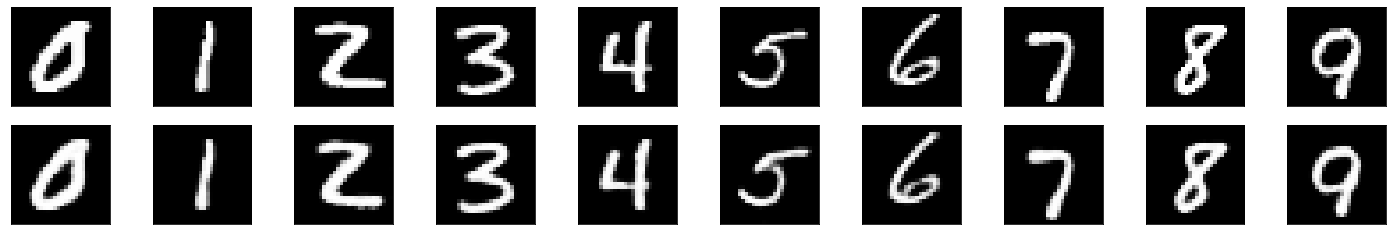

In [14]:
X = torch.Tensor(x_train_labeled.reshape(-1, 1, 28, 28))

X_reconst = model_handler_convolutional.predict(X)

N_row = 2
N_col = 10
fig, axes = plt.subplots(nrows=N_row, ncols=N_col, 
                         sharex=True, sharey=True, 
                         figsize=(25,4))

for imgs, row in zip([X.reshape(-1,28,28), 
                      X_reconst.reshape(-1,28,28)], 
                     axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Feature Extraction

## Extract Representations from Labeled Data

In [15]:
X = torch.Tensor(x_train_labeled)

representation_labeled_linear = \
    model_handler_linear.extract_representation(X)

representation_labeled_convolutional = \
    model_handler_convolutional.extract_representation(X.reshape(-1, 1, 28, 28)).squeeze()

print(f"Linear Representation Shape (labeled)        : {representation_labeled_linear.shape}")
print(f"Convolutional Representation Shape (labeled) : {representation_labeled_convolutional.shape}")

Linear Representation Shape (labeled)        : (10, 128)
Convolutional Representation Shape (labeled) : (10, 128)


## Extract Representations from Test Data

In [16]:
representation_test_linear = \
    model_handler_linear.extract_representation(test_dataloader_linear)

representation_test_convolutional = \
    model_handler_convolutional.extract_representation(test_dataloader_matrix)

print(f"Linear Representations Shape        : {representation_test_linear.shape}")
print(f"Convolutional Representations Shape : {representation_test_convolutional.shape}")

Linear Representations Shape        : (10000, 128)
Convolutional Representations Shape : (10000, 128)


# Classification

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, plot_confusion_matrix

## Dummy Classifier: Random

In [18]:
dummies = ["stratified", "most_frequent", "uniform"]
for strategy in dummies:    
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train_labeled, y_train_labeled)
    print(f"{strategy} -> {dummy_clf.score(x_test, y_test)}")

stratified -> 0.0997
most_frequent -> 0.098
uniform -> 0.1017


## KNN: ONLY LABELED DATA WITH RAW DATA

In [19]:
knn_raw = KNeighborsClassifier(n_neighbors=1)
knn_raw.fit(x_train_labeled, y_train_labeled)

preds_raw = knn_raw.predict(x_test) 

print(classification_report(y_test, preds_raw))

              precision    recall  f1-score   support

           0       0.63      0.33      0.44       980
           1       0.43      0.93      0.59      1135
           2       0.78      0.17      0.28      1032
           3       0.56      0.43      0.49      1010
           4       0.55      0.46      0.50       982
           5       0.35      0.44      0.39       892
           6       0.62      0.68      0.65       958
           7       0.58      0.63      0.60      1028
           8       0.57      0.47      0.51       974
           9       0.31      0.33      0.32      1009

    accuracy                           0.49     10000
   macro avg       0.54      0.49      0.48     10000
weighted avg       0.54      0.49      0.48     10000



## KNN: ONLY LABELED DATA WITH REPRESENTATIONS

In [20]:
knn_linear = KNeighborsClassifier(n_neighbors=1)
knn_linear.fit(representation_labeled_linear, y_train_labeled)

knn_convolutional = KNeighborsClassifier(n_neighbors=1)
knn_convolutional.fit(representation_labeled_convolutional, y_train_labeled)

KNeighborsClassifier(n_neighbors=1)

In [21]:
preds_linear = knn_linear.predict(representation_test_linear)

preds_convolutional = knn_convolutional.predict(representation_test_convolutional)

### KNN Report Linear

In [22]:
print(classification_report(y_test, preds_linear))

              precision    recall  f1-score   support

           0       0.41      0.25      0.31       980
           1       0.56      0.84      0.67      1135
           2       0.63      0.26      0.37      1032
           3       0.56      0.38      0.46      1010
           4       0.43      0.41      0.42       982
           5       0.23      0.42      0.30       892
           6       0.67      0.46      0.54       958
           7       0.52      0.67      0.59      1028
           8       0.55      0.39      0.45       974
           9       0.29      0.40      0.34      1009

    accuracy                           0.45     10000
   macro avg       0.48      0.45      0.44     10000
weighted avg       0.49      0.45      0.45     10000



### KNN Report Convolutional

In [23]:
print(classification_report(y_test, preds_convolutional))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       980
           1       0.63      0.87      0.73      1135
           2       0.79      0.25      0.38      1032
           3       0.54      0.60      0.57      1010
           4       0.67      0.48      0.55       982
           5       0.48      0.37      0.42       892
           6       0.80      0.67      0.73       958
           7       0.63      0.74      0.68      1028
           8       0.47      0.55      0.51       974
           9       0.34      0.47      0.39      1009

    accuracy                           0.56     10000
   macro avg       0.58      0.55      0.55     10000
weighted avg       0.58      0.56      0.55     10000



## LABEL THE UNLABELED DATA

In [24]:
dataset_train = \
    TensorDataset(torch.Tensor(x_train_unlabeled.reshape(-1, 1, 28, 28)), 
                  torch.zeros(x_train_unlabeled.shape[0]))

train_dataloader_matrix_noshuffle = DataLoader(dataset_train,
                                               batch_size=20,
                                               shuffle=False,
                                               num_workers=8,
                                               pin_memory=False)

In [25]:
representation_unlabaled_convolutional = \
    model_handler_convolutional.extract_representation(train_dataloader_matrix_noshuffle)

In [26]:
preds_unlabeled = \
    knn_convolutional.predict(representation_unlabaled_convolutional)

In [27]:
new_representations = np.concatenate((representation_labeled_convolutional,
                                      representation_unlabaled_convolutional))
new_labels = np.concatenate((y_train_labeled, preds_unlabeled))

print(f"New Training Data Shape: {new_representations.shape}")

New Training Data Shape: (60008, 128)


## KNN: NEW DATASET (LABELED + UNLABELED)

In [28]:
knn_new = KNeighborsClassifier(n_neighbors=300)
knn_new.fit(new_representations, new_labels)

KNeighborsClassifier(n_neighbors=300)

In [29]:
%%time
preds_new_data = knn_new.predict(representation_test_convolutional)

CPU times: user 1min 47s, sys: 86.9 ms, total: 1min 47s
Wall time: 1min 47s


In [30]:
print(classification_report(y_test, preds_new_data))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63       980
           1       0.73      0.89      0.80      1135
           2       0.99      0.31      0.47      1032
           3       0.61      0.79      0.69      1010
           4       0.73      0.52      0.61       982
           5       0.68      0.41      0.51       892
           6       0.92      0.88      0.90       958
           7       0.65      0.85      0.74      1028
           8       0.58      0.67      0.62       974
           9       0.42      0.47      0.44      1009

    accuracy                           0.65     10000
   macro avg       0.69      0.65      0.64     10000
weighted avg       0.69      0.65      0.64     10000

